In [3]:
import pandas as pd
import scanpy as sc
import os
import anndata as ad
os.chdir('../')
datasets = pd.read_csv('resources/datasets/meta/filtered_datasets.csv')

Choose two sets to harmonize/merge and load:

In [13]:
# get pre-processed datasets
ds1 = sc.read('resources/datasets/data/AdamsonWeissman2016_GSM2406675_10X001.h5ad')
ds2 = sc.read('resources/datasets/data/AdamsonWeissman2016_GSM2406677_10X005.h5ad')

2. Merge datasets

In [68]:
# define map of datasets to be merged, reduce to hvgs
ds_map = {
    'AdamsonWeissman2016_GSM2406675_10X001': ds1,
    'AdamsonWeissman2016_GSM2406677_10X005': ds2
}
# construct merged dataset
merged = ad.concat(ds_map, label='dataset')

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [54]:
import numpy as np
mean_vars = np.mean([v.n_vars for v in ds_map.values()])
# observe merged dataset vs. originals
print(f'merged dataset has: {merged.shape[1]} hvgs; mean hvgs over all datasets: {mean_vars}')

merged dataset has: 467 hvgs; mean hvgs over all datasets: 973.0


Visualize merged set without harmonization

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


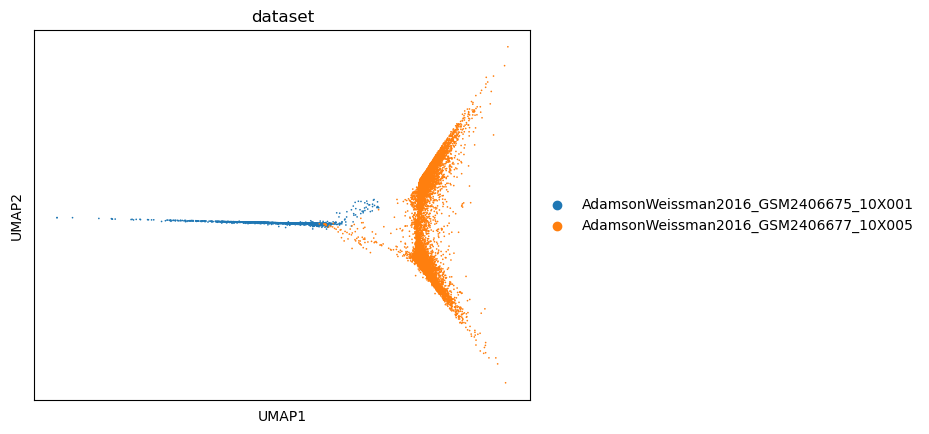

In [55]:
# Perform PCA for visualization
sc.pp.pca(merged)
# Visualize the batches in PCA space
sc.pp.neighbors(merged, use_rep='X_pca')
sc.tl.umap(merged)
sc.pl.umap(merged, color='dataset')

3. Harmonize / batch effect correction
3.1 Harmonypy

2024-09-20 12:41:53,562 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-20 12:41:59,000 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-20 12:41:59,122 - harmonypy - INFO - Iteration 1 of 10
2024-09-20 12:42:06,028 - harmonypy - INFO - Iteration 2 of 10
2024-09-20 12:42:12,576 - harmonypy - INFO - Converged after 2 iterations
/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


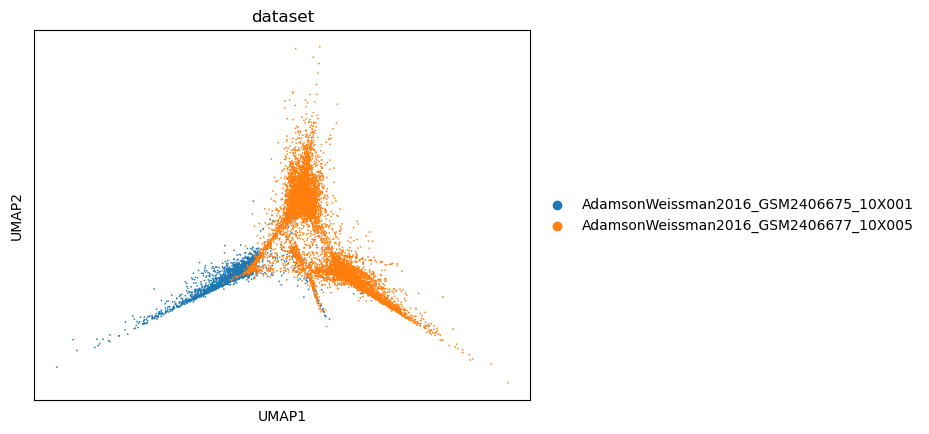

In [56]:
import harmonypy as hm
# run harmony
ho = hm.run_harmony(merged.obsm['X_pca'], merged.obs, 'dataset')
# Replace the PCA coordinates with Harmony-corrected ones
merged.obsm['X_pca_harmony'] = ho.Z_corr.T

# Perform UMAP or clustering using Harmony-corrected embeddings
sc.pp.neighbors(merged, use_rep='X_pca_harmony')
sc.tl.umap(merged)
sc.pl.umap(merged, color='dataset')

3.2 BBKNN

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


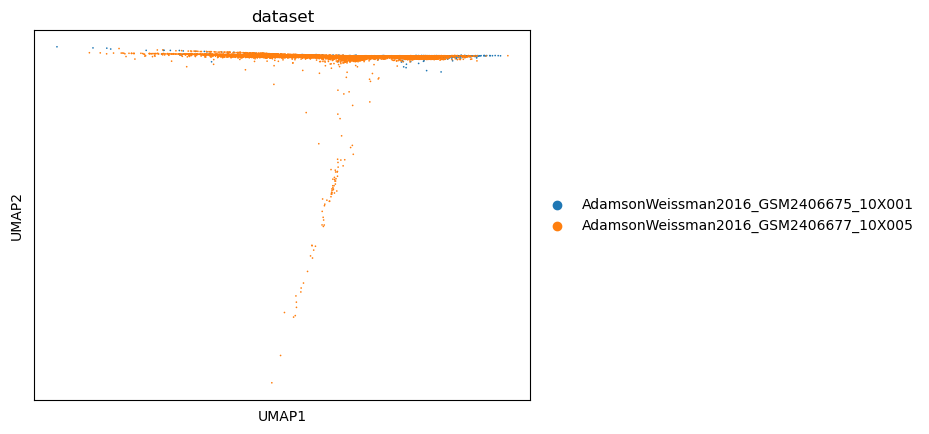

In [57]:
import bbknn
bk = merged.copy()
bbknn.bbknn(bk, batch_key='dataset')
sc.tl.umap(bk)
sc.pl.umap(bk, color='dataset')

3.3 Mutual nearest neighbors (MNN)

In [42]:
import mnnpy
keys = [*ds_map.keys()]
idx = [*range(len(keys))]

adata_mnn = mnnpy.mnn_correct(
    merged,
    batch_key='dataset',
    batch_categories=keys,
    index_list=idx  # Indices of batches to correct
)[0]

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


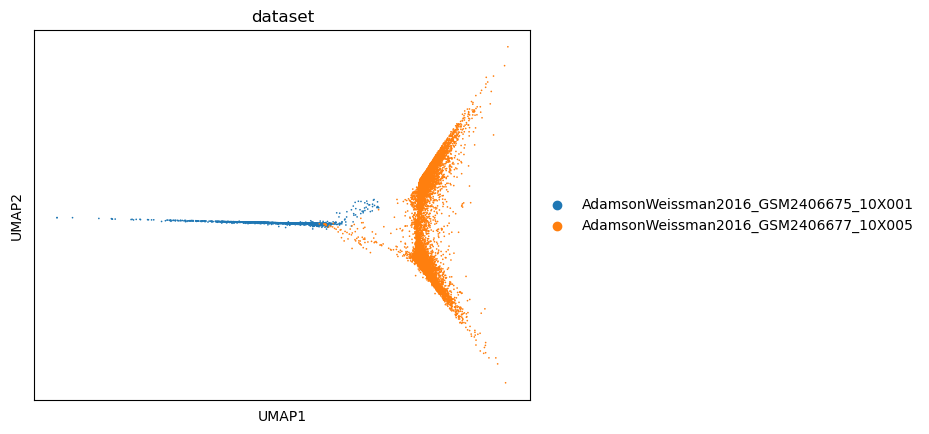

In [44]:
# Perform downstream analysis
sc.pp.neighbors(adata_mnn)
sc.tl.umap(adata_mnn)
# sc.tl.leiden(adata_mnn)

# Visualize results
sc.pl.umap(adata_mnn, color=['dataset'])

Overall:
--> Harmony looks promising
--> BBKNN not quite as good, but way faster
--> MNN does not really work

--> try both Harmony and BBKNN

In [264]:
metaset = sc.read('results/qc:True;n_hvg:10000;subset_hvg:False;hvg:True;zero_padding:True;correction_method:skip/perturb_metaset.h5ad')

In [278]:
scaled_metaset = sc.read('results/qc:True;scale:True;n_hvg:10000;subset_hvg:False;hvg:True;zero_padding:False/perturb_metaset.h5ad')

In [279]:
test = scaled_metaset.copy()

/Users/leonschwartz/miniforge3/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


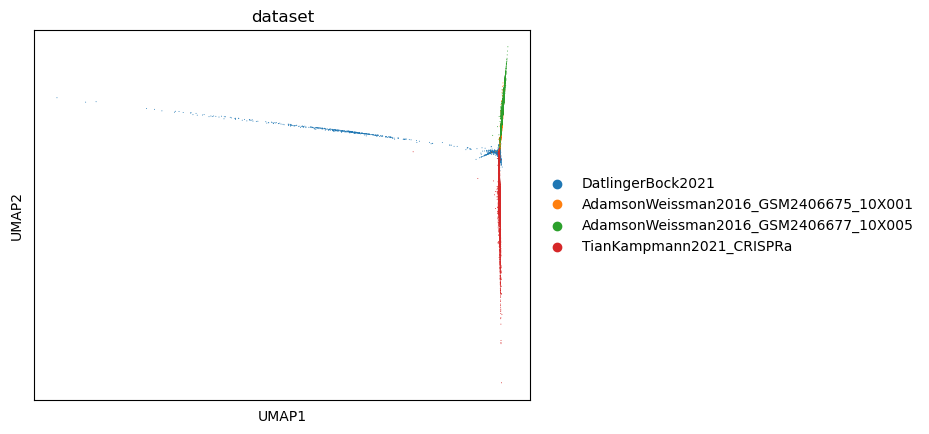

In [280]:
# Perform PCA for visualization
sc.pp.pca(test)
# Visualize the batches in PCA space
sc.pp.neighbors(test, use_rep='X_pca')
sc.tl.umap(test)
sc.pl.umap(test, color='dataset')

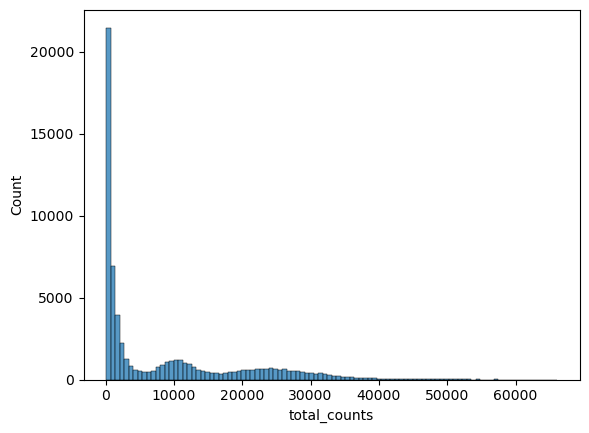

In [281]:
import seaborn as sns
p3 = sns.histplot(test.obs["total_counts"], bins=100, kde=False)

In [285]:
test.obs['scaled_total_counts'] = np.array(test.X.sum(axis=1)).flatten()

Apply scaling and centering to each dataset

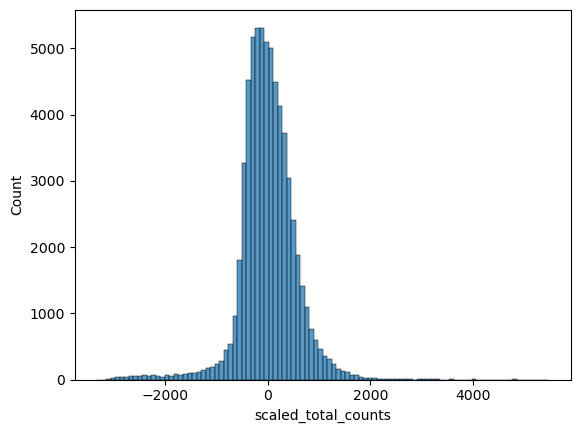

In [286]:
p2 = sns.histplot(test.obs['scaled_total_counts'], bins=100, kde=False)

<AxesSubplot: xlabel='log1p_total_counts', ylabel='Count'>

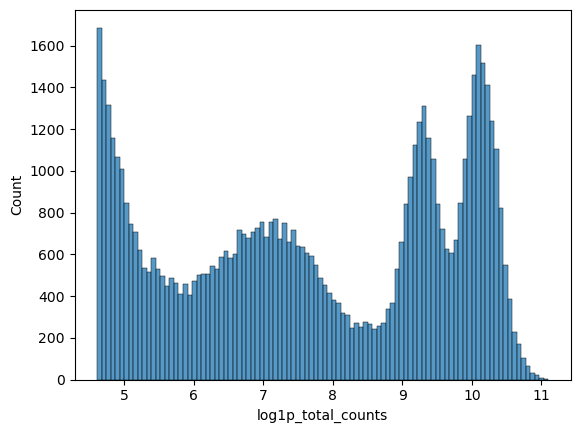

In [287]:
# Without scaling
sns.histplot(test.obs['log1p_total_counts'], bins=100, kde=False)

But, counts are a bit tight, so normalize again

In [291]:
# tanh scaling
test.layers['tanh'] = np.tanh(test.X)

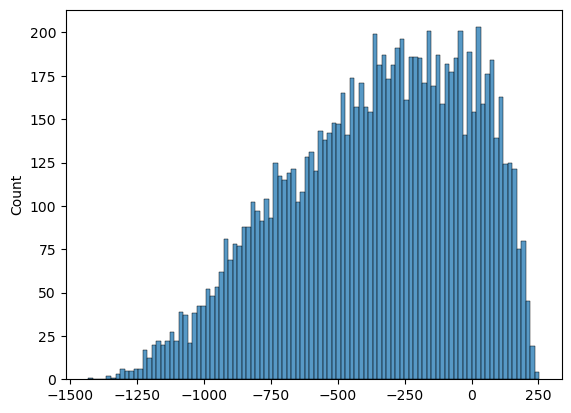

In [293]:
sns.histplot(np.array(test.layers['tanh'].sum(axis=1)).flatten(), bins=100, kde=False)

<AxesSubplot: ylabel='Count'>

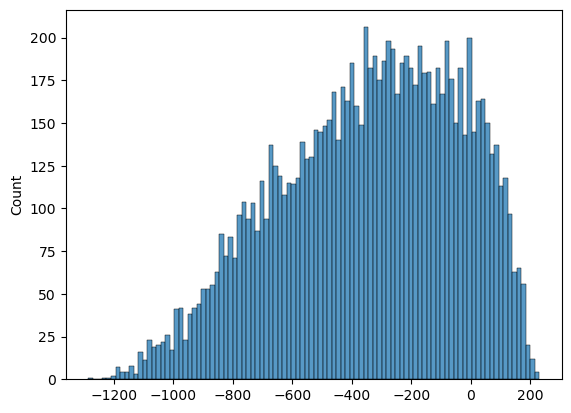

In [294]:
# log scaling
# Apply an exponential scaling (soft thresholding)
test.layers['scaled_log'] = np.sign(test.X) * np.log1p(np.abs(test.X))
sns.histplot(np.array(test.layers['scaled_log'].sum(axis=1)).flatten(), bins=100, kde=False)

<AxesSubplot: ylabel='Count'>

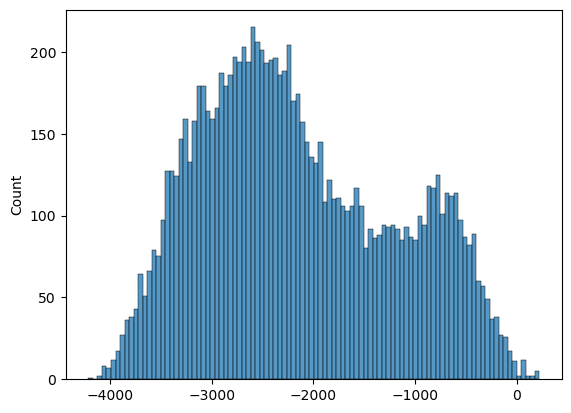

In [295]:
# Square root transformation to smooth out spiky values
test.layers['scaled_square'] = np.sign(test.X) * np.sqrt(np.abs(test.X))
sns.histplot(np.array(test.layers['scaled_square'].sum(axis=1)).flatten(), bins=100, kde=False)

In [296]:
test

AnnData object with n_obs × n_vars = 65451 × 16081
    obs: 'perturbation', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'dataset', 'scaled_total_counts'
    var: 'ensembl_id', 'hb', 'highly_variable', 'mt', 'ribo', 'dispersions', 'dispersions_norm', 'log1p_mean_counts', 'log1p_total_counts', 'mean', 'mean_counts', 'means', 'n_cells_by_counts', 'ncells', 'ncounts', 'pct_dropout_by_counts', 'std', 'total_counts'
    uns: 'pca', 'neighbors', 'umap', 'dataset_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'tanh', 'scaled_log', 'scaled_square'